In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date, datetime as dt
import numpy as np
from tqdm import tqdm
import altair as alt
from vega_datasets import data
import re
import math
sns.set(font_scale = 1.2)
sns.set_style("ticks")

In [2]:
final_df = pd.read_pickle('./models/OCR_Speller/final_dataset_social.pkl')

In [6]:
communities = dict(zip([-95355317, -57846937, -158490202, -131489096,  -91050183, -28468381,  -25679656], 
                       ['4ch', 'mudakoff', 'scolu', 'weirdreparametrizationtrick', 'dayvinchik', 'jokesss', 'sarsar']))

In [7]:
communities

{-95355317: '4ch',
 -57846937: 'mudakoff',
 -158490202: 'scolu',
 -131489096: 'weirdreparametrizationtrick',
 -91050183: 'dayvinchik',
 -28468381: 'jokesss',
 -25679656: 'sarsar'}

In [3]:
final_df.shape

(202330, 26)

In [5]:
final_df['id_community'].value_counts()

-57846937     58617
-25679656     57004
-91050183     33014
-28468381     23168
-95355317     16898
-158490202    13156
-131489096      473
Name: id_community, dtype: int64

In [4]:
final_df.loc[final_df['text_post'].str.contains('Двач|Дваch|Двach'), 'text_post'] = np.nan

In [5]:
final_df.replace("", np.nan, inplace=True)

In [6]:
final_df.drop(final_df[final_df['text_post'].notna() & final_df['text_post'].str.contains('http|заказ|ссылк|кешбэк|fastppc|\.com|\.ru|club')].index, inplace=True)

In [7]:
final_df.shape

(201377, 26)

In [8]:
final_df.drop(final_df[final_df['description_image'].notna() & final_df['description_image'].str\
             .contains('collage|comparison|compilation|composite|difference|(((two|three|four|five|six|seven|eight|nine)|((montage|group|bunch|couple|sequence|series) of))' + 
                       '( different)? (pictures|images|screenshots|drawings|paintings))' + 
                       '|((different|some|and) (pictures|images|screenshots|drawings|paintings))|and (a|an) (picture|meme|screenshot|drawing|painting|cartoon|image)')].index, inplace=True)

/home/sergey/.local/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [9]:
final_df.shape

(176781, 26)

In [10]:
final_df.to_pickle('./models/OCR_Speller/final_dataset_social_08_06_22.pkl')

In [213]:
final_df.loc[final_df['description_image'].notna() & final_df['description_image'].str.contains(' and a '), 'description_image'].sample(20).tolist()

In [17]:
final_df.loc[final_df['description_image'].notna() & final_df['description_image'].str.contains(' soviet '), ['id_community', 'id_post', 'description_image']]

,id_community,id_post,description_image
29989,-57846937,38511242,a poster of the soviet communist party with th...
31138,-57846937,38197357,a propaganda poster from the soviet era showin...
34124,-57846937,37157910,a map of the soviet union with the name of the...
34939,-57846937,36833136,a propaganda poster from the soviet era advert...
41286,-57846937,30365835,a propaganda poster from the soviet era showin...
41749,-57846937,30157370,a propaganda poster from the soviet era depict...
51071,-57846937,24082039,the history of the soviet tank and the ukraini...
52877,-57846937,22481372,a propaganda map of the soviet union and a pro...
54208,-57846937,21647585,the front and back of the soviet union banknotes
61589,-57846937,16424886,a propaganda poster for the communist party of...


In [214]:
final_df.shape

In [12]:
df_likes = final_df[['id_community', 'id_post', 'date_posted', 'count_likes']]
# del final_df

In [13]:
communities = dict(zip([-95355317, -57846937, -158490202, -131489096,  -91050183, -28468381,  -25679656], 
                       ['Двач', 'MDK', 'Мемы про школу', 'Мемы про машинное обучение', 'Леонардо Дайвинчик', 'Юмор категории Б', 'Тонкий юмор']))

### Квантили

In [14]:
q_likes = dict()
for c in df_likes['id_community'].unique():
    g_df1 = df_likes.set_index(['id_community', 'date_posted']).xs(key=c, axis=0, level='id_community').groupby(by=[pd.Grouper(freq='M')])
    q_likes[c] = pd.DataFrame(g_df1['count_likes'].quantile([0.05, 0.25, 0.75, 0.95])).reset_index()\
          .rename(columns={'level_1':'q'}).pivot(index='date_posted', columns='q', values='count_likes')\
          .rename(columns=lambda x: 'q' + str(x))
df_q_likes = pd.concat(q_likes)
df_q_likes

q                       q0.05    q0.25   q0.75    q0.95
          date_posted                                  
-95355317 2018-11-30    73.00   118.50   228.0   373.70
          2018-12-31    73.10   104.25   211.5   297.75
          2019-01-31    65.00   106.00   199.5   328.10
          2019-02-28    82.00   141.00   249.0   372.60
          2019-03-31    60.90   131.00   286.0   446.50
...                       ...      ...     ...      ...
-25679656 2022-01-31   540.10   850.00  1793.0  3283.40
          2022-02-28   532.50   831.00  1785.5  3808.50
          2022-03-31   729.40  1263.00  2604.0  5009.80
          2022-04-30   793.25  1199.75  2478.0  7246.50
          2022-05-31   655.00  1086.00  2376.0  8320.00

[567 rows x 4 columns]

In [13]:
def define_popularity_class(row):
    q = df_q_likes.loc[(row['id_community'], row['date_posted'].to_period('M').to_timestamp('M'))]
    if q['q0.05'] < row['count_likes'] < q['q0.25']:
        return 0
    elif q['q0.75'] < row['count_likes'] < q['q0.95']:
        return 1
    else: 
        return np.nan

In [14]:
final_df['pop_class'] = sine_popularity_class, axis=1)


### Количество лайков / количество просмотров

In [16]:
final_df.eval('likes_per_views = count_likes / (count_views + 1)', inplace=True)

In [20]:
df_likes = final_df[['id_community', 'id_post', 'date_posted', 'likes_per_views']]

In [19]:
final_df.head()

,id_community,id_post,date_posted,count_likes,count_views,count_comments,count_reposts,text_post,image_url,post_url,...,level_sentiment_post_2,sentiment_text_ocr_image_1,sentiment_text_ocr_image_2,level_sentiment_ocr_1,level_sentiment_ocr_2,description_image,spell_text_with_re,perc_unk_words,perc_unk_words_re,likes_per_views
1,-95355317,2106041,2022-05-12 12:03:02,6,6342.0,4,9,NaN,https://sun1-18.userapi.com/s/v1/ig2/gwRD8wNJH...,https://vk.com/wall-95355317_2106041,...,0.106701,neutral,positive,0.986787,0.016925,the evolution of korean beauty in 2018 and 2020,когда вс жизнь мечтала стать парнем,0.666667,0.000000,0.000946
3,-95355317,2106029,2022-05-12 10:03:00,9,8934.0,7,5,NaN,https://sun1-55.userapi.com/s/v1/ig2/iyfPNRSKA...,https://vk.com/wall-95355317_2106029,...,0.106701,neutral,negative,0.976321,0.275140,a small console table is made out of a metal,не могу понять стоит или лежит,0.000000,0.000000,0.001007
5,-95355317,2105981,2022-05-11 19:10:00,378,23118.0,2,161,NaN,https://sun1-96.userapi.com/s/v1/ig2/0Etc7GMf3...,https://vk.com/wall-95355317_2105981,...,0.106701,neutral,skip,0.362979,0.239359,the face of a monkey on a screenshot of a cell...,влад крутится ли воздух внутри колеса вчера в ...,0.354167,0.125000,0.016350
6,-95355317,2105977,2022-05-11 17:10:00,32,5581.0,0,42,NaN,https://sun1-83.userapi.com/s/v1/ig2/YQU9ENzXN...,https://vk.com/wall-95355317_2105977,...,0.106701,neutral,skip,0.992889,0.020974,a screenshot of a cell phone message with a cake,это мы когда отмечаете один день без ссор ещё...,0.272727,0.058824,0.005733
8,-95355317,2105968,2022-05-11 12:10:00,19,5397.0,0,23,NaN,https://sun1-54.userapi.com/s/v1/ig2/2mVk4bj_j...,https://vk.com/wall-95355317_2105968,...,0.106701,neutral,positive,0.737168,0.445540,a woman is making a bed with a clock,сегоднялягулоракьше интересно что такого случ...,0.250000,0.083333,0.003520


In [14]:
final_df.dropna(subset=['likes_per_views'], inplace=True)

In [88]:
final_df['id_community_str'] = final_df['id_community'].astype(str)

/home/sergey/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/sergey/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/sergey/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


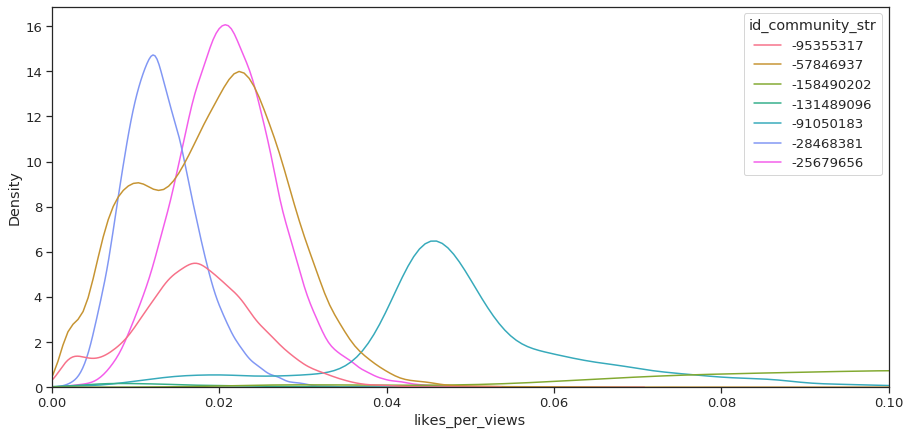

In [96]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_xlim((0, 0.1))
sns.set_palette(sns.color_palette("husl", 7))
sns.kdeplot(data=final_df, x='likes_per_views', hue='id_community_str')

In [77]:

df_q_likes = pd.concat(q_likes)
df_q_likes

q                         q0.05     q0.25     q0.75     q0.95
          date_posted                                        
-95355317 2018-11-30   0.008195  0.012134  0.018409  0.022143
          2018-12-31   0.009580  0.013235  0.020207  0.024978
          2019-01-31   0.009408  0.013316  0.021976  0.027752
          2019-02-28   0.012906  0.019011  0.027742  0.033776
          2019-03-31   0.009587  0.017931  0.029054  0.035034
...                         ...       ...       ...       ...
-25679656 2022-01-31   0.010896  0.015474  0.024028  0.030905
          2022-02-28   0.010983  0.015678  0.024243  0.031354
          2022-03-31   0.010654  0.016270  0.024942  0.031773
          2022-04-30   0.011629  0.016371  0.025274  0.033054
          2022-05-31   0.009797  0.015779  0.025154  0.035949

[420 rows x 4 columns]

In [21]:
q_likes = dict()
for c in df_likes['id_community'].unique():
    g_df1 = df_likes.set_index(['id_community', 'date_posted']).xs(key=c, axis=0, level='id_community').groupby(by=[pd.Grouper(freq='M')])
    q_likes[c] = pd.DataFrame(g_df1['likes_per_views'].quantile([0.05, 0.25, 0.75, 0.95])).reset_index()\
          .rename(columns={'level_1':'q'}).pivot(index='date_posted', columns='q', values='likes_per_views')\
          .rename(columns=lambda x: 'q' + str(x))
df_q_likes = pd.concat(q_likes)
df_q_likes

q                         q0.05     q0.25     q0.75     q0.95
          date_posted                                        
-95355317 2018-11-30   0.008195  0.012134  0.018409  0.022143
          2018-12-31   0.009580  0.013235  0.020207  0.024978
          2019-01-31   0.009408  0.013316  0.021976  0.027752
          2019-02-28   0.012906  0.019011  0.027742  0.033776
          2019-03-31   0.009587  0.017931  0.029054  0.035034
...                         ...       ...       ...       ...
-25679656 2022-01-31   0.010896  0.015474  0.024028  0.030905
          2022-02-28   0.010983  0.015678  0.024243  0.031354
          2022-03-31   0.010654  0.016270  0.024942  0.031773
          2022-04-30   0.011629  0.016371  0.025274  0.033054
          2022-05-31   0.009797  0.015779  0.025154  0.035949

[567 rows x 4 columns]

In [82]:
def make_plots_popular_views(my_df, owner_id_comm):
    
    q_likes = dict()
    g_df1 = my_df.set_index(['id_community', 'date_posted']).xs(key=owner_id_comm, axis=0, level='id_community').groupby(by=[pd.Grouper(freq='M')])
    q_likes = pd.DataFrame(g_df1['likes_per_views'].quantile([0.05, 0.25, 0.75, 0.95])).reset_index()\
          .rename(columns={'level_1':'q'}).pivot(index='date_posted', columns='q', values='likes_per_views')\
          .rename(columns=lambda x: 'q' + str(x))
    
    f = plt.figure(figsize=(15, 7))
    plt.fill_between(q_likes.index, q_likes['q0.05'], q_likes['q0.25'], alpha=0.5, 
                     facecolor='firebrick', label='низкая (L<Q1)')
    plt.fill_between(q_likes.index, q_likes['q0.25'], q_likes['q0.75'], alpha=0.5,
                     facecolor='grey', label='средняя (Q1<L<Q3)')
    plt.fill_between(q_likes.index, q_likes['q0.75'], q_likes['q0.95'], alpha=0.5,
                     facecolor='forestgreen', label='высокая (L>Q3)')
    plt.plot(q_likes['q0.25'], c='firebrick', lw=0.8)
    plt.plot(q_likes['q0.75'], c='forestgreen', lw=0.8)
    plt.title('Сообщество: ' + communities[owner_id_comm])
    plt.xlabel('Дата')
    plt.ylabel('% одобрений от просмотров')
    plt.legend()
    plt.savefig(f'/home/sergey/maga_diploma/{communities[owner_id_comm]}_likes_per_views.png')
    return plt

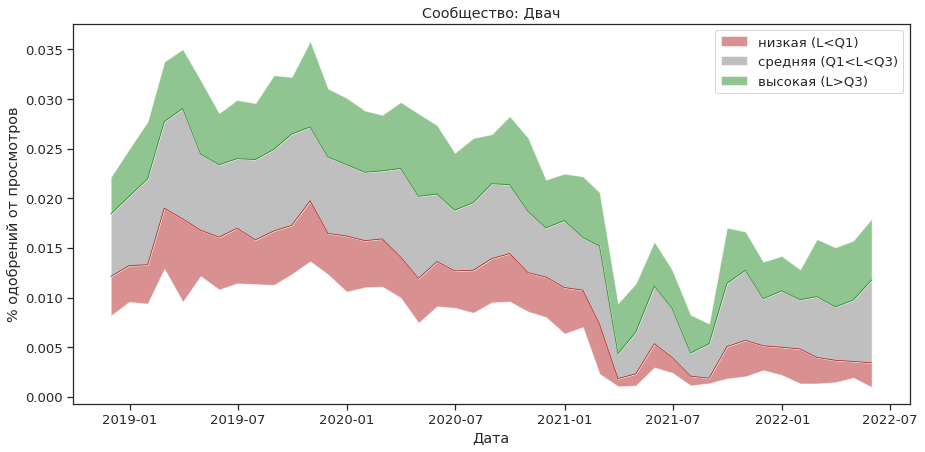

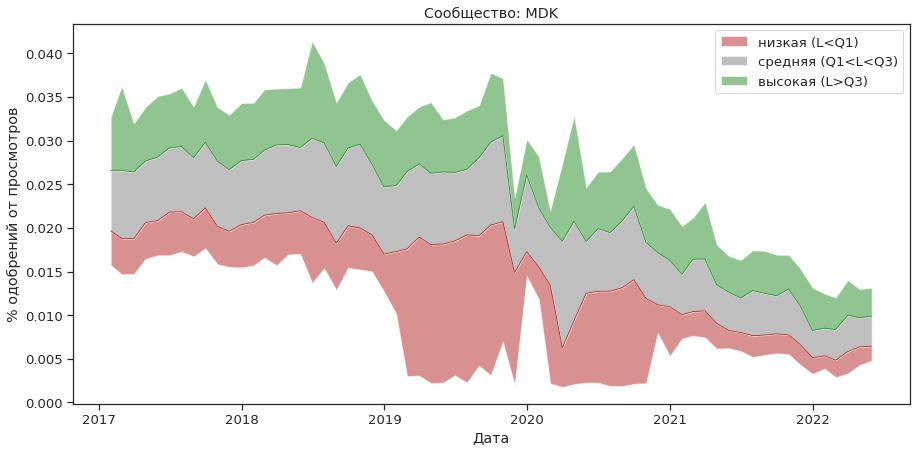

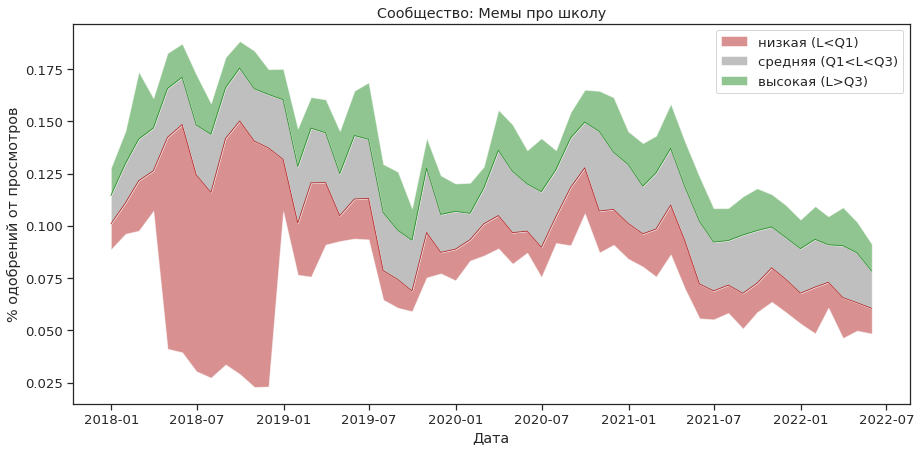

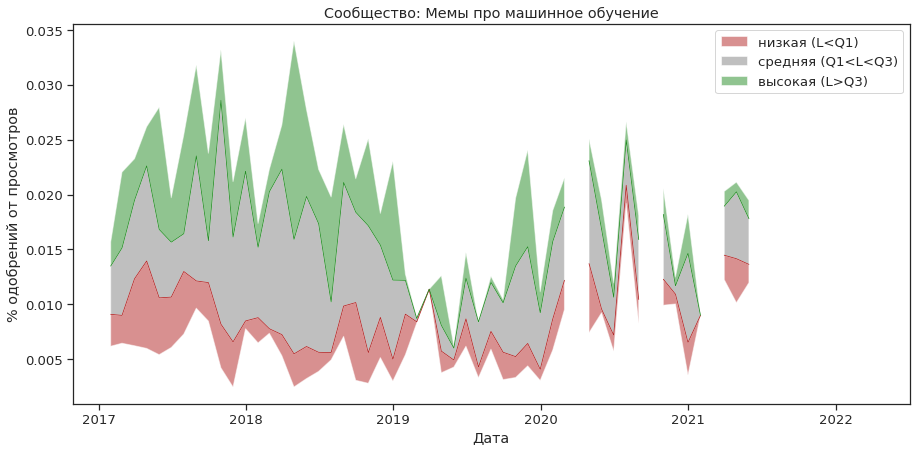

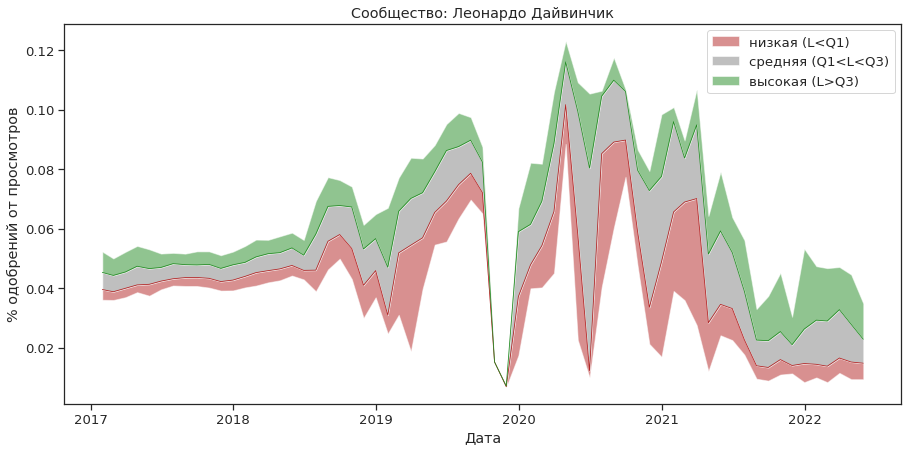

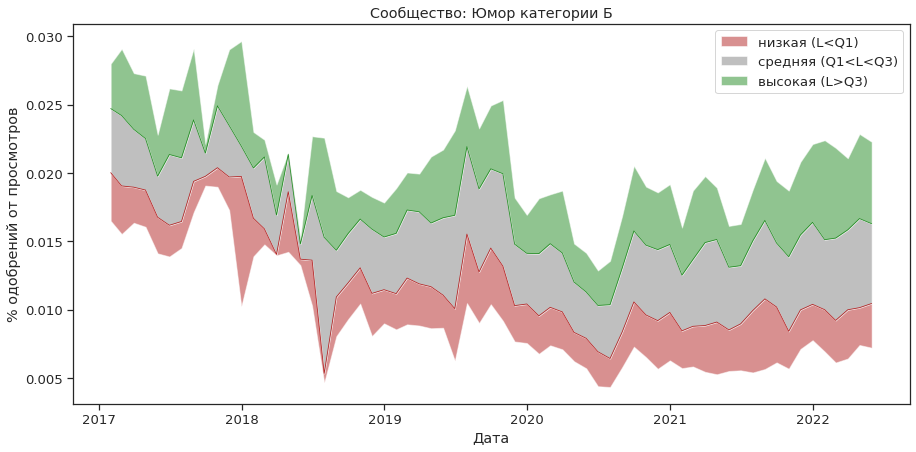

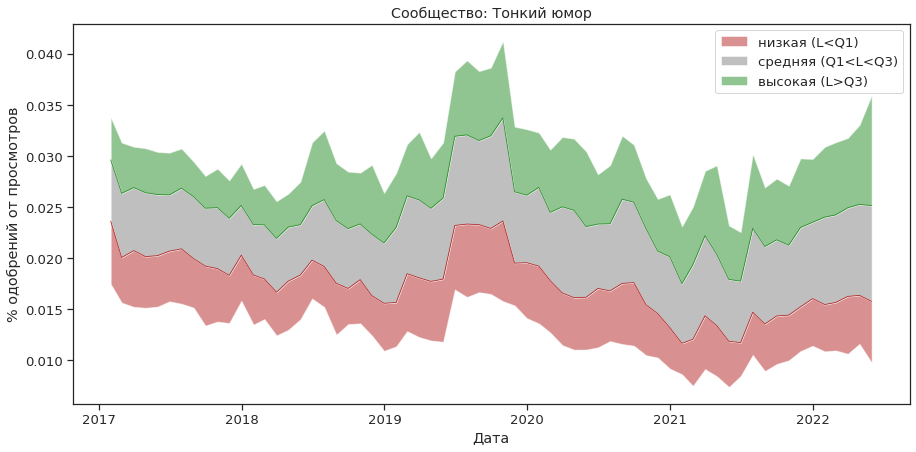

In [83]:
for own_id in final_df['id_community'].astype(str).unique():
    make_plots_popular_views(final_df, int(own_id))

In [22]:
def define_popularity_class_views(row):
    q = df_q_likes.loc[(row['id_community'], row['date_posted'].to_period('M').to_timestamp('M'))]
    if q['q0.05'] < row['likes_per_views'] < q['q0.25']:
        return 0
    elif q['q0.75'] < row['likes_per_views'] < q['q0.95']:
        return 1
    else: 
        return np.nan

In [27]:
print('[0.3, 0.2, ..]')
print('[0.2, 0.1, ..]')

[0.3, 0.2, ..]
[0.2, 0.1, ..]


In [23]:
final_df['pop_class'] = final_df.apply(define_popularity_class_views, axis=1)

In [24]:
final_df.shape

(176781, 28)

In [ ]:
final_df.to_pickle()

In [105]:
final_df.pop_class.unique()

array([nan,  0.,  1.])

In [25]:
final_df.to_pickle('/home/sergey/maga_diploma/models/OCR_Speller/final_dataset_social_08_06_22_v2.pkl')

In [15]:
final_df.shape

(176781, 27)

In [15]:
final_df.to_pickle('./models/embedding/filtered_dataset_v2.pkl')

In [3]:
final_df = pd.read_pickle('./models/embedding/filtered_dataset_v2.pkl')

In [4]:
final_df.shape

(176781, 27)

In [ ]:
final_df.isna().sum(axis=0)

In [ ]:
filtered_df = final_df.dropna(subset=['type_post', 'pop_class', 'spell_text_with_re', 'description_image'])

In [3]:
filtered_df.shape

NameError: name 'filtered_df' is not defined

### Изображение

In [ ]:
filtered_df = final_df.dropna(subset=['type_post', 'pop_class', 'description_image'])

In [27]:
final_filtered_df = filtered_df.loc[filtered_df['type_post'] == 'image']

In [28]:
final_filtered_df.shape

(6047, 27)

In [29]:
final_filtered_df.to_pickle('./models/embedding/final_filter_dataset_social_image_v2.pkl')

In [ ]:
# filtered_df_text = filtered_df[filtered_df['type_post'] == 'text']
# filtered_df_text = filtered_df_text[filtered_df_text['size_text_ocr'] > 0]

### Текст

In [25]:
filtered_df = final_df.dropna(subset=['type_post', 'pop_class', 'spell_text_with_re'])

In [28]:
filtered_df.columns

Index(['id_community', 'id_post', 'date_posted', 'count_likes', 'count_views',
       'count_comments', 'count_reposts', 'text_post', 'image_url', 'post_url',
       'type_post', 'text_ocr_image', 'size_text_ocr', 'spell_text_ocr_image',
       'sentiment_text_post_1', 'sentiment_text_post_2',
       'level_sentiment_post_1', 'level_sentiment_post_2',
       'sentiment_text_ocr_image_1', 'sentiment_text_ocr_image_2',
       'level_sentiment_ocr_1', 'level_sentiment_ocr_2', 'description_image',
       'spell_text_with_re', 'perc_unk_words', 'perc_unk_words_re',
       'pop_class'],
      dtype='object')

In [33]:
final_filtered_df = filtered_df.loc[(filtered_df['type_post'] == 'text') & (filtered_df['size_text_ocr'] > 0)]

In [34]:
final_filtered_df.shape

(25671, 27)

In [35]:
final_filtered_df.to_pickle('./models/embedding/final_filter_dataset_social_text_v2.pkl')

### С опциональным текстом

In [16]:
filtered_df = final_df.dropna(subset=['type_post', 'pop_class', 'description_image'])

In [32]:
filtered_df.loc[filtered_df['type_post'] == 'image'].dropna(subset=['text_post'])

(4577, 27)

In [33]:
final_filtered_df = filtered_df.loc[filtered_df['type_post'] == 'image'].dropna(subset=['text_post'])

In [34]:
final_filtered_df.to_pickle('./models/embedding/final_filter_dataset_social_image_v3.pkl')

In [ ]:
print(filtered_df.shape)
filtered_df.head(30)

In [ ]:
final_filtered_df.shape

In [ ]:
final_filtered_df.to_pickle('./models/embedding/final_filter_dataset_social.pkl')

In [267]:
final_df.shape

(176781, 27)

In [268]:
filtered_df = final_df.dropna(subset=['type_post', 'pop_class', 'spell_text_with_re', 'description_image'])

In [270]:
final_filtered_df = filtered_df.loc[filtered_df['perc_unk_words_re'] < 0.35]

In [272]:
final_filtered_df.shape

(30994, 27)

In [273]:
final_filtered_df.to_pickle('./models/embedding/final_filter_dataset_social_v2.pkl')

In [ ]:
#list(filtered_df.spell_text_with_re.values)

In [ ]:
filtered_df.loc[201736]

In [ ]:
filtered_df.loc[8]

In [ ]:
i = 12
print(filtered_df.loc[i]['text_ocr_image'])
print(filtered_df.loc[i]['spell_text_ocr_image'])
print(filtered_df.loc[i]['spell_text_with_re'])

In [ ]:
sns.kdeplot(filtered_df['perc_unk_words'])
sns.kdeplot(filtered_df['perc_unk_words_re'])
plt.show()

/home/sergey/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/sergey/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/sergey/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/sergey/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]

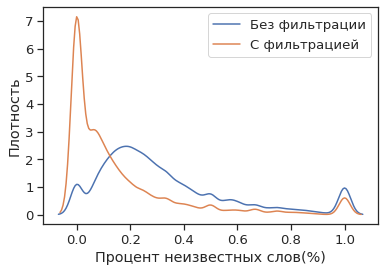

In [23]:
sns.kdeplot(final_df['perc_unk_words']).set(xlabel='Процент неизвестных слов(%)', ylabel='Плотность')
sns.kdeplot(final_df['perc_unk_words_re'], label="EEEEE")
plt.legend(labels=["Без фильтрации","С фильтрацией"])
# ax = sns.barplot(x = 'val', y = 'cat', 
#               data = fake, 
#               color = 'black')
# ax.set(xlabel='common xlabel', ylabel='common ylabel')
# sns.set_xlabel("Процент неизвестных слов", fontsize=14)
# sns.set_ylabel("Плотность", fontsize=14);
plt.show()

In [68]:
df_likes = final_df[['id_community', 'id_post', 'date_posted', 'count_likes']]

In [11]:
communities = dict(zip([-95355317, -57846937, -158490202, -131489096,  -91050183, -28468381,  -25679656], ['Двач', 'MDK', 'Мемы про школу', 'Мемы про машинное обучение', 'Леонардо Дайвинчик', 'Юмор категории Б', 'Тонкий юмор']))

In [71]:
def make_plots_popular(my_df, owner_id_comm):
    
    q_likes = dict()
    g_df1 = my_df.set_index(['id_community', 'date_posted']).xs(key=owner_id_comm, axis=0, level='id_community').groupby(by=[pd.Grouper(freq='M')])
    q_likes = pd.DataFrame(g_df1['count_likes'].quantile([0.05, 0.25, 0.75, 0.95])).reset_index()\
          .rename(columns={'level_1':'q'}).pivot(index='date_posted', columns='q', values='count_likes')\
          .rename(columns=lambda x: 'q' + str(x))
    
    f = plt.figure(figsize=(15, 7))
    plt.fill_between(q_likes.index, q_likes['q0.05'], q_likes['q0.25'], alpha=0.5, 
                     facecolor='firebrick', label='низкая (L<Q1)')
    plt.fill_between(q_likes.index, q_likes['q0.25'], q_likes['q0.75'], alpha=0.5,
                     facecolor='grey', label='средняя (Q1<L<Q3)')
    plt.fill_between(q_likes.index, q_likes['q0.75'], q_likes['q0.95'], alpha=0.5,
                     facecolor='forestgreen', label='высокая (L>Q3)')
    plt.plot(q_likes['q0.25'], c='firebrick', lw=0.8)
    plt.plot(q_likes['q0.75'], c='forestgreen', lw=0.8)
    plt.title('Сообщество: ' + communities[owner_id_comm])
    plt.xlabel('Дата')
    plt.ylabel('Количество одобрений')
    plt.savefig(f'/home/sergey/maga_diploma/{communities[owner_id_comm]}_likes.png')
    plt.legend()
    return plt

In [12]:
final_df['id_community'].astype(str).unique()

array(['-95355317', '-57846937', '-158490202', '-131489096', '-91050183',
       '-28468381', '-25679656'], dtype=object)

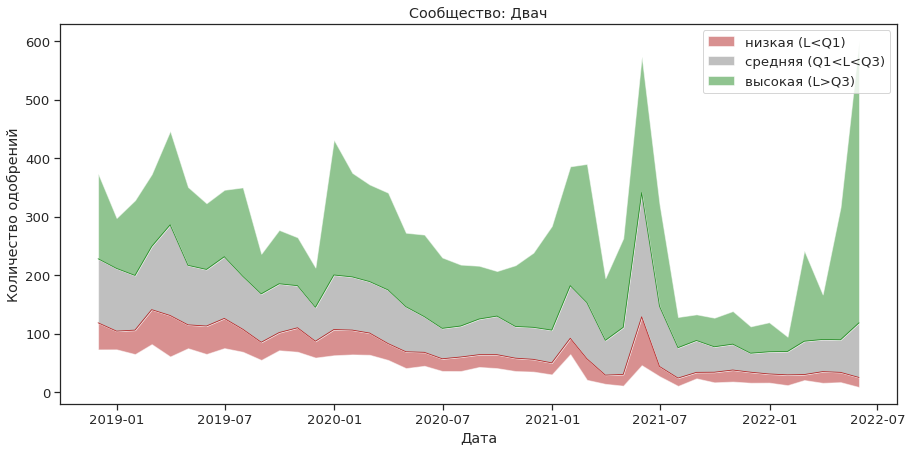

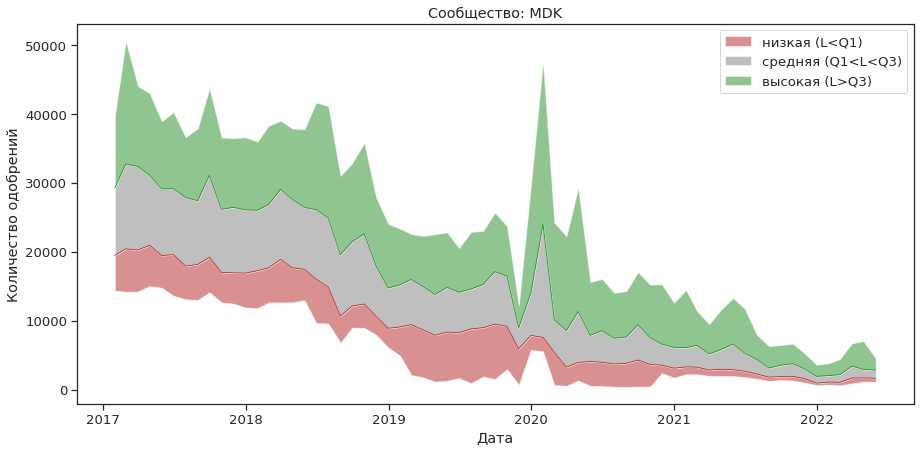

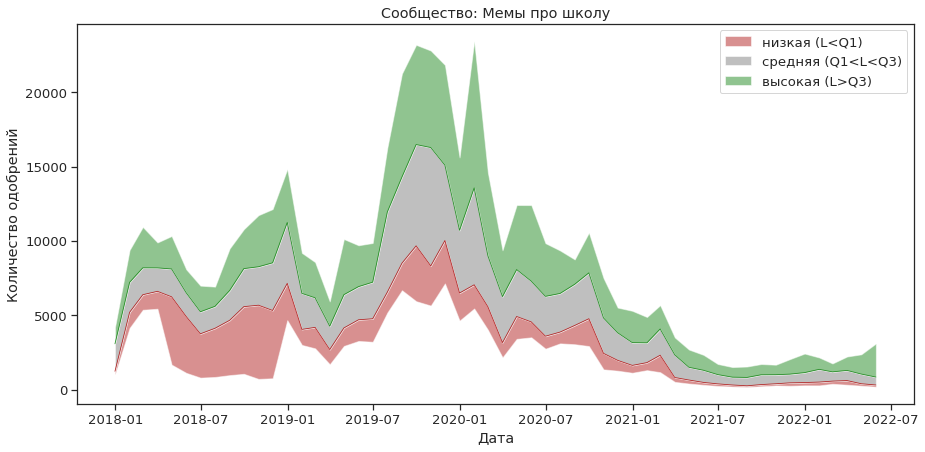

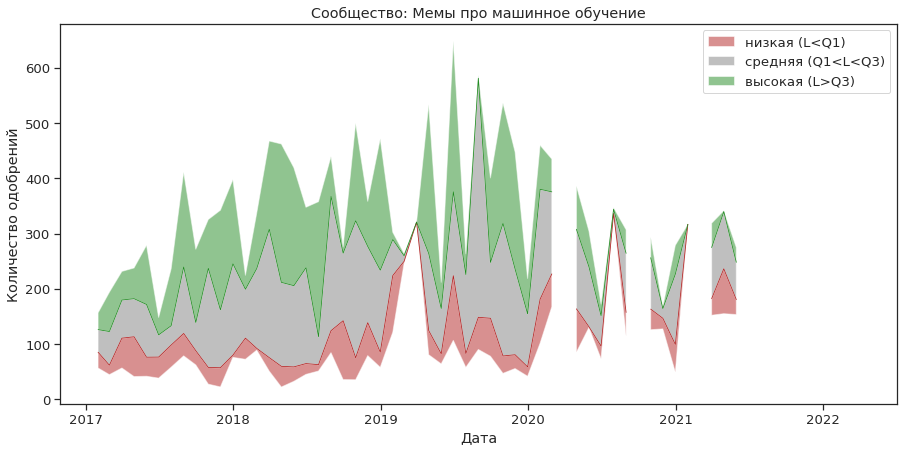

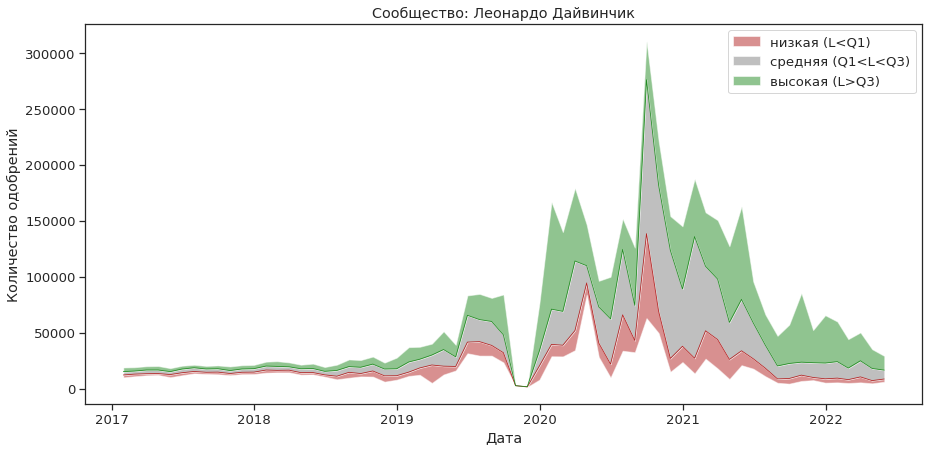

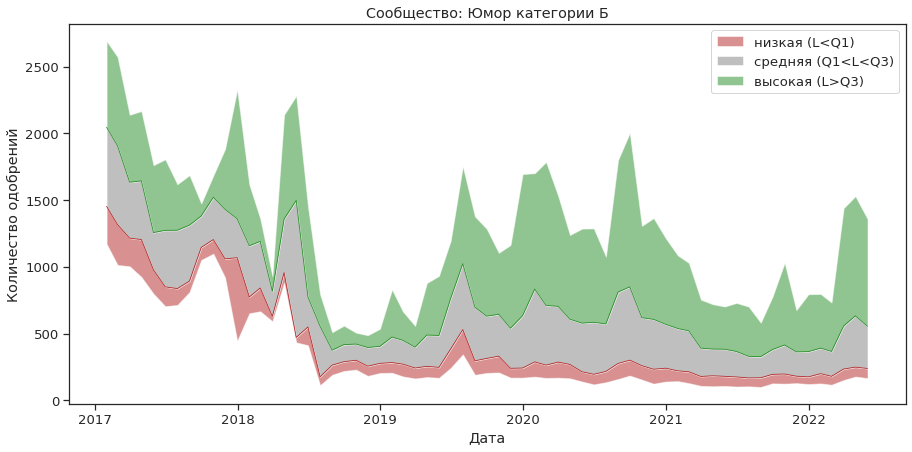

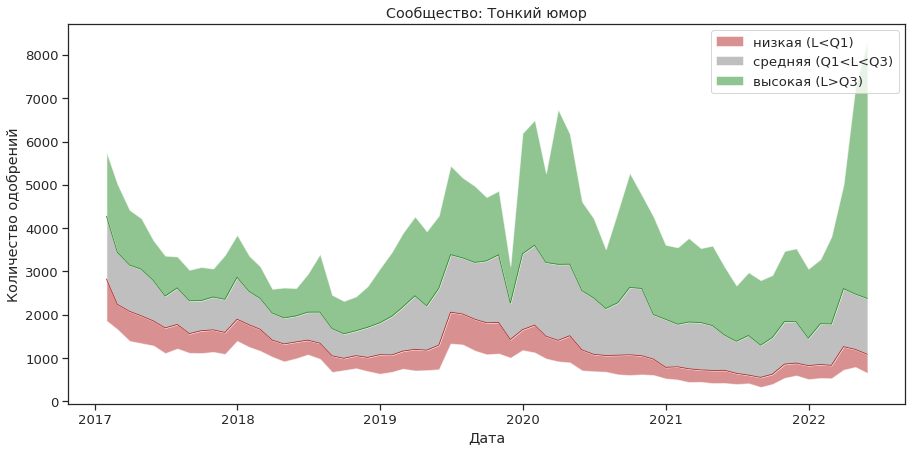

In [72]:
for own_id in final_df['id_community'].astype(str).unique():
    make_plots_popular(df_likes, int(own_id))